# Exercise 8 Part 2: Curse of Dimensionality - Full Sheetwise Regression Analysis

This notebook performs a comprehensive regression analysis for each sheet in the Excel file `curse-of-dimensionality.xlsx`. Each sheet is treated as a separate dataset, and the following steps are performed for each:

## Sub Tasks
1. Data preprocessing (imputation, encoding)
2. Train/test split
3. Iterative modeling with varying train sizes (R², MAE)
4. Subplots for R² and MAE vs. train size
5. Pairwise correlation analysis and heatmap
6. VIF analysis and progressive feature elimination
7. PCA and regression model comparison

In [11]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_absolute_error, classification_report
)
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

In [12]:
# 2. Load curse-of-dimensionality.xlsx (Multiple Sheets)
curse_xlsx = pd.ExcelFile('../data/curse-of-dimensionality.xlsx')
sheet_names = curse_xlsx.sheet_names
print('Sheet names:', sheet_names)
curse_sheets = {name: curse_xlsx.parse(name) for name in sheet_names}

Sheet names: ['Sheet1', 'Sheet2', 'Sheet3']


---
## Analysis for Each Sheet in curse-of-dimensionality.xlsx


===== Sheet: Sheet1 =====
Fraction: 1.00, TrainSize: 8, R2: 0.220, MAE: 0.174
Fraction: 0.75, TrainSize: 6, R2: 0.069, MAE: 0.193
Fraction: 0.50, TrainSize: 4, R2: 0.071, MAE: 0.185
Fraction: 0.25, TrainSize: 2, R2: -6.461, MAE: 0.463


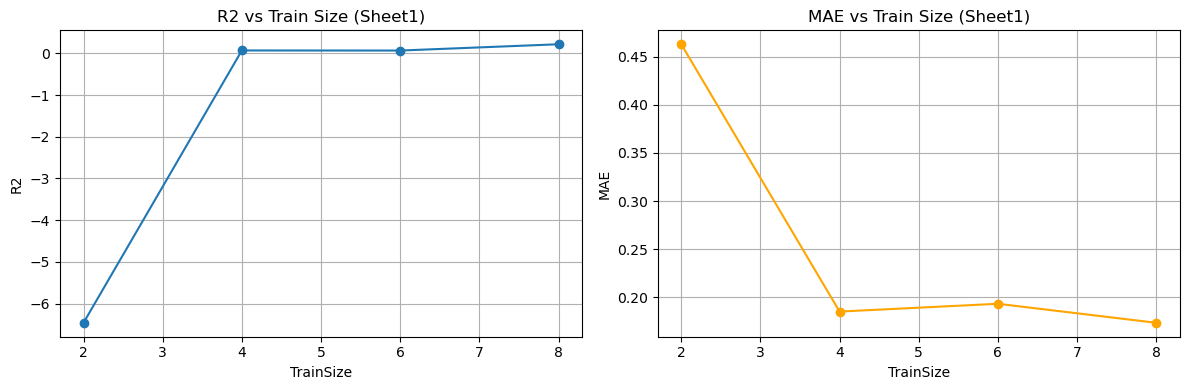


===== Sheet: Sheet2 =====
Fraction: 1.00, TrainSize: 8, R2: -13072.752, MAE: 17.119
Fraction: 0.75, TrainSize: 6, R2: -1804.516, MAE: 6.467
Fraction: 0.50, TrainSize: 4, R2: -183.117, MAE: 2.823
Fraction: 0.25, TrainSize: 2, R2: -5.127, MAE: 0.433


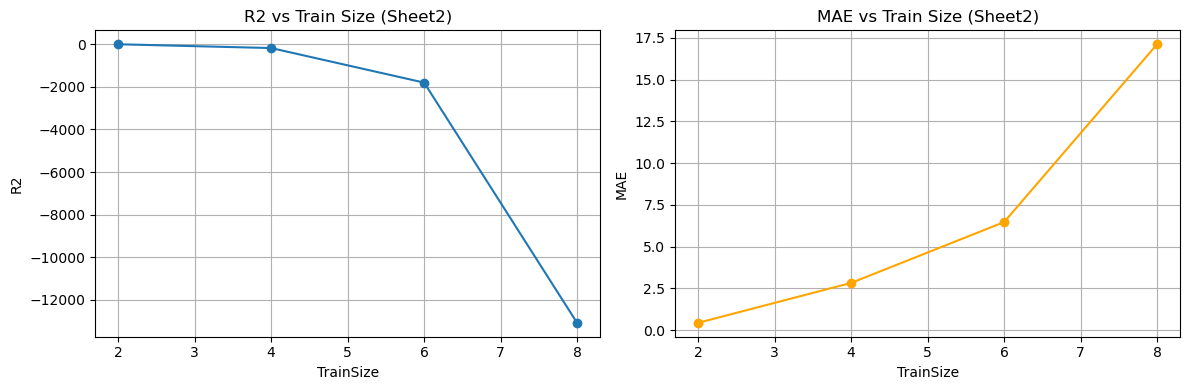


===== Sheet: Sheet3 =====
Fraction: 1.00, TrainSize: 79, R2: 0.638, MAE: 0.392
Fraction: 0.75, TrainSize: 59, R2: 0.091, MAE: 0.473
Fraction: 0.50, TrainSize: 39, R2: -0.994, MAE: 0.609
Fraction: 0.25, TrainSize: 19, R2: 0.773, MAE: 0.403


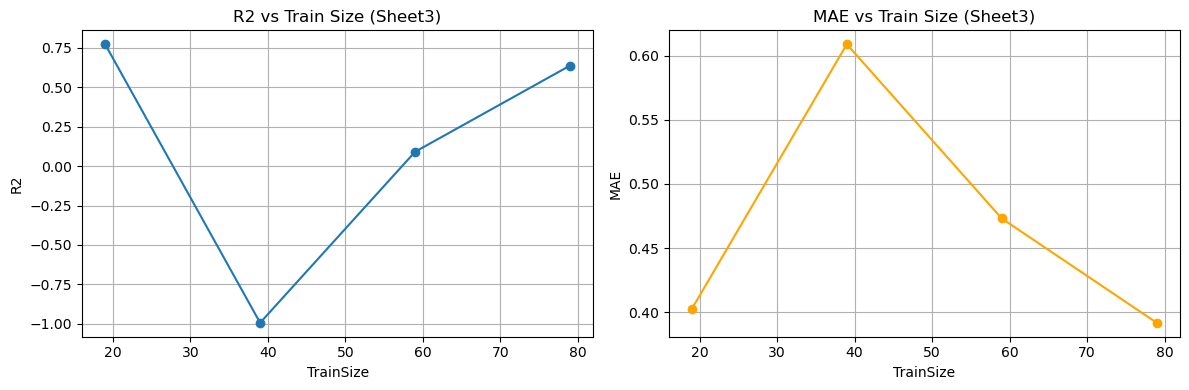

In [19]:
for sheet_name, df in curse_sheets.items():
    print(f'\n===== Sheet: {sheet_name} =====')
    df_sheet = df.copy().dropna(how='all')
    # Target column is always 'y'
    target_col = 'y'
    X = df_sheet.drop(columns=[target_col])
    y = df_sheet[target_col]
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Iteratively reduce number of observations and evaluate model metrics
    fractions = [1.0, 0.75, 0.5, 0.25]
    metrics = []
    for frac in fractions:
        n_samples = int(len(X_train) * frac)
        X_sub = X_train.sample(n=n_samples, random_state=42)
        y_sub = y_train.loc[X_sub.index]
        model = LinearRegression()
        model.fit(X_sub, y_sub)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        metrics.append({'Fraction': frac, 'TrainSize': n_samples, 'R2': r2, 'MAE': mae})
        print(f'Fraction: {frac:.2f}, TrainSize: {n_samples}, R2: {r2:.3f}, MAE: {mae:.3f}')
        
        
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(metrics_df['TrainSize'], metrics_df['R2'], marker='o')
    axes[0].set_title(f'R2 vs Train Size ({sheet_name})')
    axes[0].set_xlabel('TrainSize')
    axes[0].set_ylabel('R2')
    axes[0].grid(True)
    axes[1].plot(metrics_df['TrainSize'], metrics_df['MAE'], marker='o', color='orange')
    axes[1].set_title(f'MAE vs Train Size ({sheet_name})')
    axes[1].set_xlabel('TrainSize')
    axes[1].set_ylabel('MAE')
    axes[1].grid(True)
    plt.tight_layout()
    plt.show()


===== Correlation Analysis: Sheet1 =====
Not enough numeric features for correlation analysis.

===== Correlation Analysis: Sheet2 =====
          x1        x2        x3        x4        x5        x6        x7  \
x1  1.000000  0.974559  0.928391  0.999989  0.999958  0.951662  0.989184   
x2  0.974559  1.000000  0.987180  0.973516  0.972493  0.863728  0.932464   
x3  0.928391  0.987180  1.000000  0.926651  0.924962  0.784746  0.868685   
x4  0.999989  0.973516  0.926651  1.000000  0.999990  0.952890  0.989796   
x5  0.999958  0.972493  0.924962  0.999990  1.000000  0.954056  0.990366   
x6  0.951662  0.863728  0.784746  0.952890  0.954056  1.000000  0.986169   
x7  0.989184  0.932464  0.868685  0.989796  0.990366  0.986169  1.000000   
x8  0.979907  0.912531  0.843269  0.980730  0.981504  0.993649  0.998546   

          x8  
x1  0.979907  
x2  0.912531  
x3  0.843269  
x4  0.980730  
x5  0.981504  
x6  0.993649  
x7  0.998546  
x8  1.000000  
Top correlated feature pairs in Sheet2 (|c

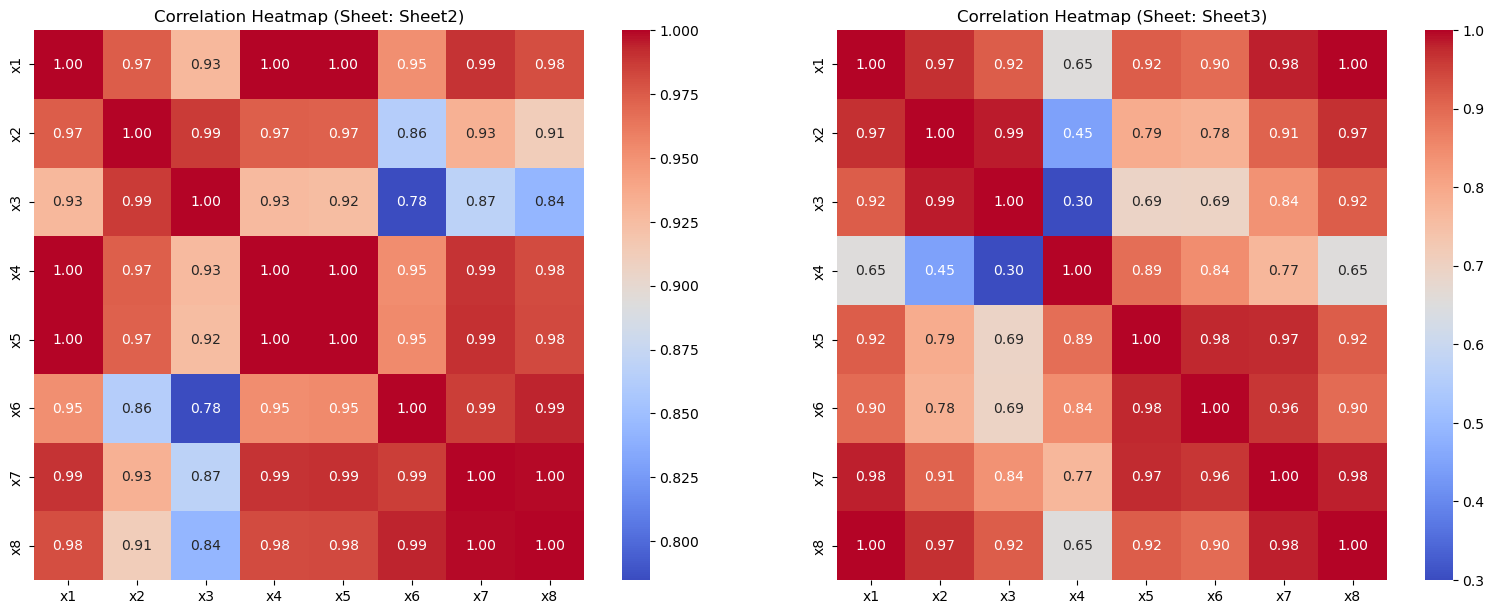

In [20]:
# 5. Pairwise correlation analysis and heatmap for each sheet (all columns numeric, no imputation/encoding needed)
num_sheets = len(curse_sheets)
fig, axes = plt.subplots(1, num_sheets, figsize=(8*num_sheets, 6))
if num_sheets == 1:
    axes = [axes]
for ax, (sheet_name, df) in zip(axes, curse_sheets.items()):
    print(f'\n===== Correlation Analysis: {sheet_name} =====')
    df_sheet = df.copy().dropna(how='all')
    target_col = 'y'
    X = df_sheet.drop(columns=[target_col])
    num_cols = X.columns  # all columns are numeric
    if len(num_cols) >= 2:
        corr = X.corr()
        print(corr)
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, ax=ax)
        ax.set_title(f'Correlation Heatmap (Sheet: {sheet_name})')
        # Show top correlated pairs (|corr| > 0.7)
        high_corr_pairs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack().sort_values(ascending=False)
        print(f'Top correlated feature pairs in {sheet_name} (|corr| > 0.7):')
        print(high_corr_pairs[high_corr_pairs.abs() > 0.7])
    else:
        ax.set_visible(False)
        print('Not enough numeric features for correlation analysis.')
plt.tight_layout()
plt.show()


===== VIF Analysis: Sheet1 =====
Not enough numeric features for VIF analysis.

===== VIF Analysis: Sheet2 =====
Initial VIF values:
  feature           VIF
0      x1           inf
1      x2  8.704498e+08
2      x3  8.263486e+13
3      x4           inf
4      x5  9.007199e+15
5      x6  1.887775e+07
6      x7  2.029087e+10
7      x8  1.012386e+10
Features with VIF > 5 (potential multicollinearity):
  feature           VIF
0      x1           inf
1      x2  8.704498e+08
2      x3  8.263486e+13
3      x4           inf
4      x5  9.007199e+15
5      x6  1.887775e+07
6      x7  2.029087e+10
7      x8  1.012386e+10
   n_features removed       max_vif max_vif_feature            R2        MAE
0           8    None           inf              x1 -13072.751929  17.118666
1           7      x1  9.005398e+11              x4 -13097.161511  17.133580
2           6      x4  1.476327e+08              x7   -946.532591   5.063305
3           5      x7  4.646927e+04              x5      0.354219   0.147

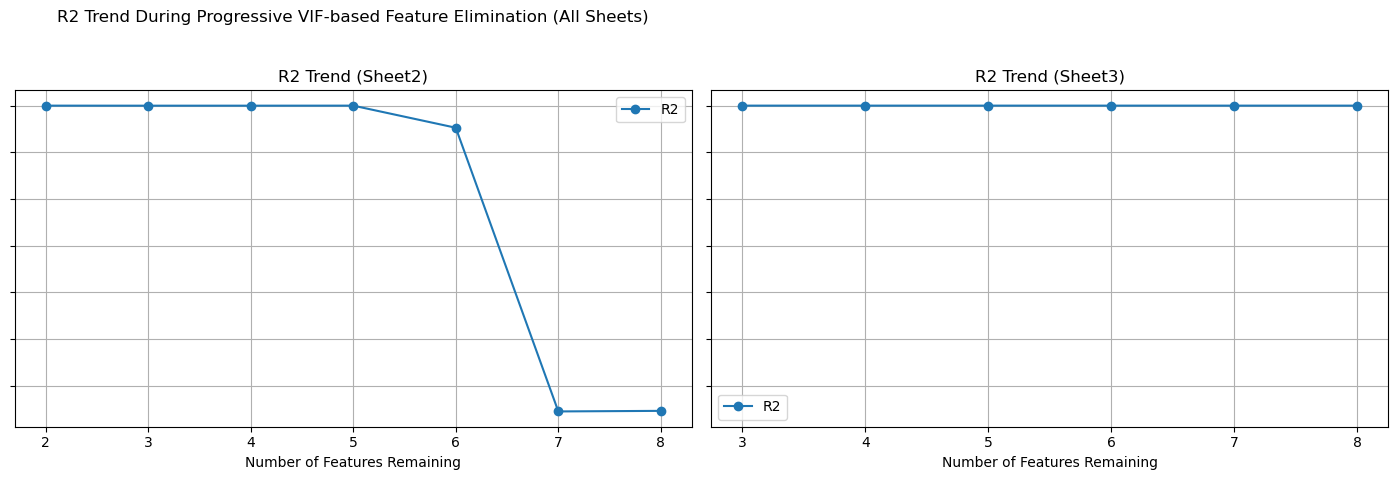

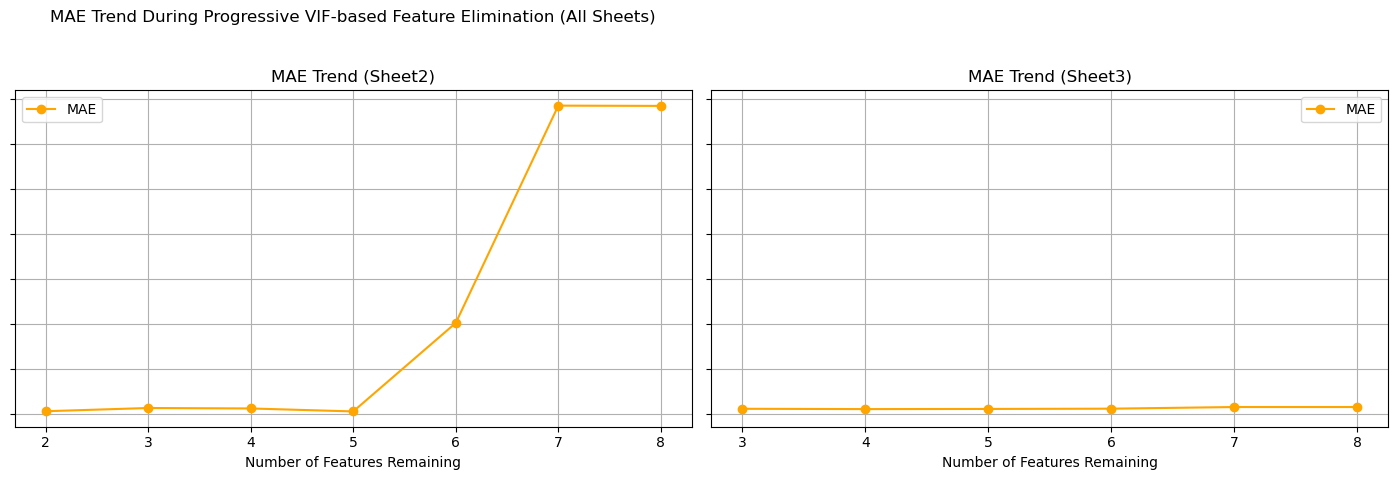

In [21]:
# 6. VIF analysis and progressive feature elimination for each sheet (all columns numeric, subplots for R2 and MAE trends)
num_sheets = len(curse_sheets)
fig_r2, axes_r2 = plt.subplots(1, num_sheets, figsize=(7*num_sheets, 5), sharey=True)
fig_mae, axes_mae = plt.subplots(1, num_sheets, figsize=(7*num_sheets, 5), sharey=True)
if num_sheets == 1:
    axes_r2 = [axes_r2]
    axes_mae = [axes_mae]
for idx, (sheet_name, df) in enumerate(curse_sheets.items()):
    print(f'\n===== VIF Analysis: {sheet_name} =====')
    df_sheet = df.copy().dropna(how='all')
    target_col = 'y'
    X = df_sheet.drop(columns=[target_col])
    y = df_sheet[target_col]
    num_cols = X.columns  # all columns are numeric
    if len(num_cols) >= 2:
        vif_data = pd.DataFrame()
        vif_data['feature'] = num_cols
        vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        print('Initial VIF values:')
        print(vif_data)
        print('Features with VIF > 5 (potential multicollinearity):')
        print(vif_data[vif_data['VIF'] > 5])
        # Progressive VIF-based feature elimination
        X_vif = X.copy()
        features_removed = []
        metrics_trend = []
        while True:
            vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])], index=X_vif.columns)
            max_vif = vif.max()
            max_vif_feature = vif.idxmax()
            X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_vif, y, test_size=0.2, random_state=42)
            model = LinearRegression()
            model.fit(X_train_v, y_train_v)
            y_pred_v = model.predict(X_test_v)
            r2 = r2_score(y_test_v, y_pred_v)
            mae = mean_absolute_error(y_test_v, y_pred_v)
            metrics_trend.append({'n_features': X_vif.shape[1], 'removed': None if not features_removed else features_removed[-1],
                                 'max_vif': max_vif, 'max_vif_feature': max_vif_feature,
                                 'R2': r2, 'MAE': mae})
            if max_vif < 5 or X_vif.shape[1] <= 1:
                break
            X_vif = X_vif.drop(columns=[max_vif_feature])
            features_removed.append(max_vif_feature)
        metrics_df = pd.DataFrame(metrics_trend)
        
        # R2 subplot
        axes_r2[idx].plot(metrics_df['n_features'], metrics_df['R2'], marker='o', label='R2')
        axes_r2[idx].set_xlabel('Number of Features Remaining')
        axes_r2[idx].set_title(f'R2 Trend ({sheet_name})')
        axes_r2[idx].legend()
        axes_r2[idx].grid(True)
        # MAE subplot
        axes_mae[idx].plot(metrics_df['n_features'], metrics_df['MAE'], marker='o', color='orange', label='MAE')
        axes_mae[idx].set_xlabel('Number of Features Remaining')
        axes_mae[idx].set_title(f'MAE Trend ({sheet_name})')
        axes_mae[idx].legend()
        axes_mae[idx].grid(True)
        print(metrics_df)
    else:
        axes_r2[idx].set_visible(False)
        axes_mae[idx].set_visible(False)
        print('Not enough numeric features for VIF analysis.')
axes_r2[0].set_ylabel('R2')
axes_mae[0].set_ylabel('MAE')
fig_r2.suptitle('R2 Trend During Progressive VIF-based Feature Elimination (All Sheets)')
fig_mae.suptitle('MAE Trend During Progressive VIF-based Feature Elimination (All Sheets)')
fig_r2.tight_layout(rect=[0, 0.03, 1, 0.95])
fig_mae.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


===== PCA Analysis: Sheet1 =====


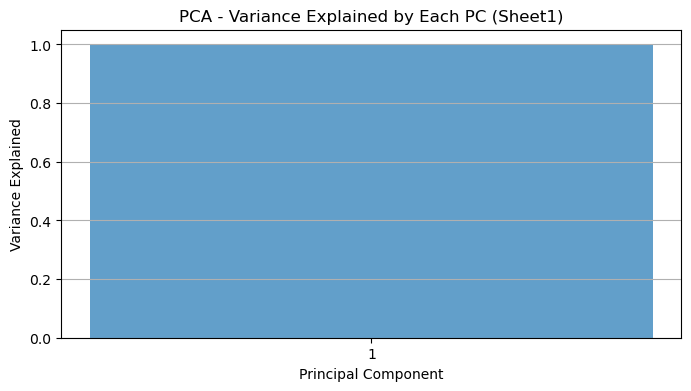

Explained variance ratio for each PC:
[1.]

===== PCA Analysis: Sheet2 =====


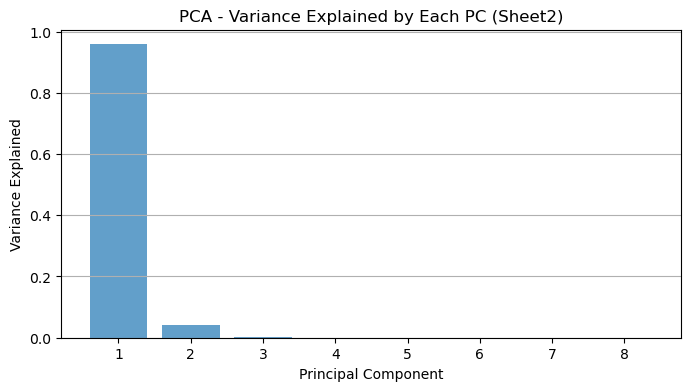

Explained variance ratio for each PC:
[9.58122901e-01 4.06089761e-02 1.25687850e-03 1.11945362e-05
 4.96054293e-08 3.83636920e-12 1.78504237e-14 9.02250082e-21]

===== PCA Analysis: Sheet3 =====


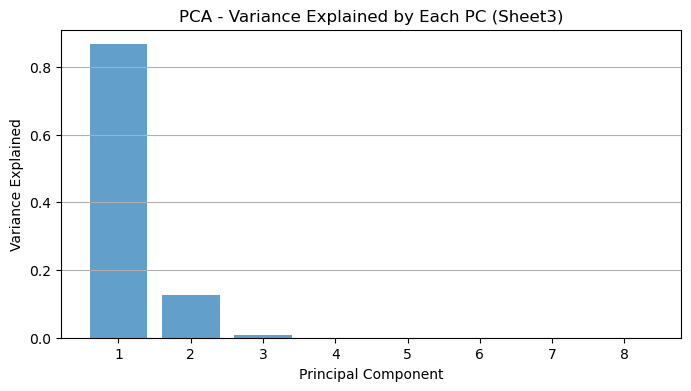

Explained variance ratio for each PC:
[8.66351063e-01 1.25638732e-01 7.46619130e-03 5.22971799e-04
 1.84009617e-05 2.63510295e-06 5.91224840e-09 9.42463325e-17]


In [22]:
# Perform PCA and plot explained variance for each sheet
from sklearn.decomposition import PCA

for sheet_name, df in curse_sheets.items():
    print(f"\n===== PCA Analysis: {sheet_name} =====")
    df_sheet = df.copy().dropna(how='all')
    X = df_sheet.drop(columns=['y'])
    
    # Standardize features before PCA
    X_std = (X - X.mean()) / X.std()
    
    pca = PCA()
    pca.fit(X_std)
    explained_var = pca.explained_variance_ratio_
    
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.title(f'PCA - Variance Explained by Each PC ({sheet_name})')
    plt.xticks(range(1, len(explained_var) + 1))
    plt.grid(axis='y')
    plt.show()
    
    print("Explained variance ratio for each PC:")
    print(explained_var)

In [23]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

for sheet_name, df in curse_sheets.items():
    print(f"\n===== PC Regression Comparison: {sheet_name} =====")
    df_sheet = df.copy().dropna(how='all')
    X = df_sheet.drop(columns=['y'])
    y = df_sheet['y']
    
    # Standardize features before PCA
    X_std = (X - X.mean()) / X.std()
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
    
    # Fit PCA on training data
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    results = []
    for n_pc in [3, 5, X.shape[1]]:
        if n_pc > X.shape[1]:
            continue
        # Use first n_pc principal components
        model = LinearRegression()
        model.fit(X_train_pca[:, :n_pc], y_train)
        y_pred = model.predict(X_test_pca[:, :n_pc])
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({'Model': f'PCs: {n_pc}', 'R2': r2, 'MAE': mae})
    
    # Model with original features
    model_orig = LinearRegression()
    model_orig.fit(X_train, y_train)
    y_pred_orig = model_orig.predict(X_test)
    r2_orig = r2_score(y_test, y_pred_orig)
    mae_orig = mean_absolute_error(y_test, y_pred_orig)
    results.append({'Model': 'Original Features', 'R2': r2_orig, 'MAE': mae_orig})
    
    results_df = pd.DataFrame(results)
    print(results_df)


===== PC Regression Comparison: Sheet1 =====
               Model        R2       MAE
0             PCs: 1  0.219716  0.173636
1  Original Features  0.219716  0.173636

===== PC Regression Comparison: Sheet2 =====
               Model            R2        MAE
0             PCs: 3     -1.325708   0.317494
1             PCs: 5      0.361058   0.144519
2             PCs: 8 -13072.685527  17.118626
3  Original Features -13072.685527  17.118626

===== PC Regression Comparison: Sheet3 =====
               Model        R2       MAE
0             PCs: 3  0.880426  0.290053
1             PCs: 5  0.882284  0.281876
2             PCs: 8  0.637927  0.391760
3  Original Features  0.637927  0.391760


Conclusion: PCA-based Regression vs. Original Features
Sheet1:

Using only the first principal component (PC1) gives the same R² and MAE as using all original features.
This suggests that almost all the variance relevant to prediction is captured by PC1, and additional features do not improve the model.
Sheet2:

Using 3 PCs results in poor performance (negative R², high MAE).
Using 5 PCs gives the best performance (R² = 0.36, MAE = 0.14).
Using all 8 PCs or all original features leads to extremely poor performance (very negative R², very high MAE), likely due to severe multicollinearity or overfitting.
Conclusion: A subset of PCs (e.g., 5) can dramatically improve model performance compared to using all original features or all PCs.
Sheet3:

Using 3 or 5 PCs gives much better R² and lower MAE than using all 8 PCs or all original features.
Using all PCs or original features reduces model performance, again likely due to multicollinearity or overfitting.
Conclusion: Dimensionality reduction via PCA (selecting 3–5 PCs) improves regression performance compared to using all original features.
Overall Conclusion:

Using all original features or all PCs can lead to poor model performance due to multicollinearity or overfitting.
Selecting an appropriate subset of principal components (not too few, not all) often yields better predictive performance (higher R², lower MAE).
PCA is an effective tool for dimensionality reduction and can help improve regression models, especially in high-dimensional or highly collinear datasets.